In [521]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
df = pd.read_csv('data/covid_19_data.csv')

In [522]:
# I referred code regarding data preprocessing from https://www.kaggle.com/chirag9073/coronavirus-covid-19-outbreak-data-analysis

df.drop(['SNo'], axis=1, inplace=True)
df['ObservationDate'] = df['ObservationDate'].apply(pd.to_datetime)

In [523]:
df.head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.000,0.000,0.000
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.000,0.000,0.000
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.000,0.000,0.000
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.000,0.000,0.000
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.000,0.000,0.000
5,2020-01-22,Guangdong,Mainland China,1/22/2020 17:00,26.000,0.000,0.000
6,2020-01-22,Guangxi,Mainland China,1/22/2020 17:00,2.000,0.000,0.000
7,2020-01-22,Guizhou,Mainland China,1/22/2020 17:00,1.000,0.000,0.000
8,2020-01-22,Hainan,Mainland China,1/22/2020 17:00,4.000,0.000,0.000
9,2020-01-22,Hebei,Mainland China,1/22/2020 17:00,1.000,0.000,0.000


In [524]:
df.isnull().sum()

ObservationDate      0
Province/State     982
Country/Region       0
Last Update          0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [525]:
df[df['Province/State'].isnull()].head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
35,2020-01-22,NaN,Japan,1/22/2020 17:00,2.000,0.000,0.000
36,2020-01-22,NaN,Thailand,1/22/2020 17:00,2.000,0.000,0.000
37,2020-01-22,NaN,South Korea,1/22/2020 17:00,1.000,0.000,0.000
73,2020-01-23,NaN,Japan,1/23/20 17:00,1.000,0.000,0.000
74,2020-01-23,NaN,Thailand,1/23/20 17:00,3.000,0.000,0.000
75,2020-01-23,NaN,South Korea,1/23/20 17:00,1.000,0.000,0.000
76,2020-01-23,NaN,Singapore,1/23/20 17:00,1.000,0.000,0.000
77,2020-01-23,NaN,Philippines,1/23/20 17:00,0.000,0.000,0.000
78,2020-01-23,NaN,Malaysia,1/23/20 17:00,0.000,0.000,0.000
79,2020-01-23,NaN,Vietnam,1/23/20 17:00,2.000,0.000,0.000


In [526]:
# Current situation
grouped_df = df.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered'].max()
grouped_df.style.background_gradient(cmap='Pastel1_r')

In [527]:
# Top 10 Countries with most no. of reported cases
latest_df = df[df['ObservationDate'] == max(df['ObservationDate'])].reset_index()
grouped_df = latest_df.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

temp = grouped_df[['Country/Region', 'Confirmed']]
temp = temp.sort_values(by='Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.head(10).style.background_gradient(cmap='Pastel1_r')

,Country/Region,Confirmed
0,Mainland China,80026
1,South Korea,4335
2,Italy,2036
3,Iran,1501
4,Others,705
5,Japan,274
6,France,191
7,Germany,159
8,Spain,120
9,Singapore,108


In [528]:
# Countries with all the cases recovered
temp = grouped_df[grouped_df['Confirmed']==grouped_df['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

,Country/Region,Confirmed,Recovered
0,Vietnam,16,16
1,Cambodia,1,1
2,Nepal,1,1
3,Sri Lanka,1,1


In [529]:
# Most recent stats
world_daily_df = df.groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
world_daily_df = world_daily_df.reset_index()
world_daily_df = world_daily_df.sort_values('ObservationDate', ascending=False)
world_daily_df.head(1).style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,90309,3085,45602


In [530]:
world_daily_df.style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,90309,3085,45602
39,2020-03-01 00:00:00,88371,2996,42716
38,2020-02-29 00:00:00,86013,2941,39782
37,2020-02-28 00:00:00,84124,2872,36711
36,2020-02-27 00:00:00,82756,2814,33277
35,2020-02-26 00:00:00,81397,2770,30384
34,2020-02-25 00:00:00,80415,2708,27905
33,2020-02-24 00:00:00,79570,2629,25227
32,2020-02-23 00:00:00,78985,2469,23394
31,2020-02-22 00:00:00,78599,2458,22886


In [531]:
world_daily_df.isnull().sum()

ObservationDate    0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

In [532]:
# from https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/
import keras

class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [533]:

import datetime
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint

WINDOW_SIZE = 8

class PandemicRegressor():
    def __init__(self, window_size, batch_size, n_feature, model_name, hidden_state=False, stateful=False, loss_hist=None):
        self.window_size = window_size
        self.batch_size = batch_size
        self.n_feature = n_feature
        save_dir = os.path.join(os.path.join(os.getcwd(), 'model'), 
                                datetime.datetime.now().strftime('%Y-%m-%d;%H.%M.%S'))
        os.mkdir(save_dir)
        self.model_path = os.path.join(save_dir, model_name + '.best.hdf5')
        print(self.model_path)
        self.hidden_state = hidden_state
        self.stateful = stateful
        if stateful:
            self.callbacks = [loss_hist]
        else:
            self.callbacks = [EarlyStopping(monitor='val_loss', patience=100), 
                 ModelCheckpoint(self.model_path, monitor='val_mape', verbose=0, save_best_only=True, mode='min')]
        self.reg = self.build_model(hidden_state, stateful)
        
    def build_model(self, hidden_state, stateful):
        model = Sequential()
        if hidden_state:
            if stateful:
                model.add(LSTM(1024, batch_input_shape=(self.batch_size, self.window_size, self.n_feature), dropout=0.5, stateful=True))
            else:
                model.add(LSTM(1024, input_shape=(self.window_size, self.n_feature), dropout=0.5))
        else:
             model.add(Dense(1024, input_dim=(self.window_size * self.n_feature),activation='relu'))
        
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.n_feature, activation='linear'))

        model.compile(loss='mean_squared_error', 
                      optimizer='adam',
                      metrics=['mae', 'mape'])
        return model
    
    def reset_states(self):
        # reset hiden states
        self.reg.reset_states()
    
    def fit(self, X_train, y_train, validation_data, epochs=500, verbose=1, shuffle=False):
        hist = self.reg.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=self.batch_size,
                            validation_data=validation_data,
                            callbacks=self.callbacks,
                            verbose=verbose,
                            shuffle=shuffle)
        return hist
    
    def predict_n_days(self, n, seq_in, scaler):
        _mean = scaler['mean']
        _std = scaler['std']
        
        if self.hidden_state:
            seq_in = list(seq_in)
            seq_out = []
            for i in range(n):
                temp = np.array(seq_in)
                temp = np.reshape(temp, (1, self.window_size, self.n_feature)) # n_sample, seq_len, n_feature
                y_hat = self.reg.predict(temp)
                seq_out.append(y_hat[0])
                y_hat = (y_hat - _mean) / _std
                seq_in.append(y_hat[0])
                seq_in.pop(0)
        else:
            seq_in = list(seq_in)
            seq_out = []
            for i in range(n):
                temp = np.array(seq_in)
                temp = np.reshape(temp, (1, self.window_size * self.n_feature)) # n_sample, seq_len, n_feature
                y_hat = self.reg.predict(temp)
                seq_out.append(y_hat[0])
                y_hat = (y_hat - _mean) / _std
                seq_in.append(y_hat[0])
                seq_in.pop(0)
        _df = pd.DataFrame(seq_out)
        _df.columns = ['Confirmed', 'Deaths', 'Recovered']
        return _df
    
    def predict(self, X):
        return self.reg.predict(X)
    
    def evaluate(self, X_test, y_test):
        loss_and_metrics = self.reg.evaluate(X_test, 
                                             y_test, 
                                             batch_size=self.batch_size)
        return loss_and_metrics
    
    def load_best_weights(self):
        self.reg.load_weights(self.model_path)
    
    def save(self):
        self.reg.save(self.model_path)


In [534]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def show_train_hist(hist):
    plt.plot(hist.history['loss'], 'b-', label='train_loss')
    plt.plot(hist.history['val_loss'], 'r', label='val_loss')
    plt.title("loss history")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Normalize
_mean = np.mean(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
_std = np.std(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)

print(_mean)
print(_std)

[46077.41463415  1313.85365854 11462.34146341]
[31966.13245523  1056.92768198 13683.82920771]


In [535]:
def seq2dataset(sr, window_size):
        seq_data = []
        for i in range(len(sr) - window_size):
            subset = list(sr[i:(i+window_size+1)])
            subset.reverse()
            seq_data.append(subset)
        seq_data.reverse()
        seq_data = np.array(seq_data)
        return seq_data[:,0:window_size,:], seq_data[:,window_size,:]

In [536]:
X, y = seq2dataset(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, WINDOW_SIZE)
X

array([[[  555.,    17.,    28.],
        [  653.,    18.,    30.],
        [  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.]],

       [[  653.,    18.,    30.],
        [  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        [ 8235.,   171.,   143.]],

       [[  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        [ 8235.,   171.,   143.],
        [ 9925.,   213.,   222.]],

       [[ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        

In [537]:
y

array([[ 8235.,   171.,   143.],
       [ 9925.,   213.,   222.],
       [12038.,   259.,   284.],
       [16787.,   362.,   472.],
       [19881.,   426.,   623.],
       [23892.,   492.,   852.],
       [27636.,   564.,  1124.],
       [30818.,   634.,  1487.],
       [34392.,   719.,  2011.],
       [37121.,   806.,  2616.],
       [40151.,   906.,  3244.],
       [42763.,  1013.,  3946.],
       [44803.,  1113.,  4683.],
       [45222.,  1118.,  5150.],
       [60370.,  1371.,  6295.],
       [66887.,  1523.,  8058.],
       [69032.,  1666.,  9395.],
       [71226.,  1770., 10865.],
       [73260.,  1868., 12583.],
       [75138.,  2007., 14352.],
       [75641.,  2122., 16121.],
       [76199.,  2247., 18177.],
       [76843.,  2251., 18890.],
       [78599.,  2458., 22886.],
       [78985.,  2469., 23394.],
       [79570.,  2629., 25227.],
       [80415.,  2708., 27905.],
       [81397.,  2770., 30384.],
       [82756.,  2814., 33277.],
       [84124.,  2872., 36711.],
       [86

In [538]:
X = (X - _mean) / _std

In [539]:
X

array([[[-1.42408265, -1.22700321, -0.83560978],
        [-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804]],

       [[-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804],
        [-1.18382837, -1.08129788, -0.8272057 ]],

       [[-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.2669

In [540]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

C:\Users\codez\PycharmProjects\CoronavirusDisease2019\model\2020-03-05;02.59.00\world_dense_pdm_reg.best.hdf5
Train on 28 samples, validate on 5 samples
Epoch 1/3000
28/28 [==============================] - 2s 63ms/step - loss: 1151912818.2857 - mae: 20800.5137 - mape: 100.0010 - val_loss: 3017859840.0000 - val_mae: 42955.2773 - val_mape: 99.9937
Epoch 2/3000
28/28 [==============================] - 0s 2ms/step - loss: 1151493659.4286 - mae: 20795.5625 - mape: 99.8889 - val_loss: 3015379968.0000 - val_mae: 42938.5156 - val_mape: 99.9433
Epoch 3/3000
28/28 [==============================] - 0s 1ms/step - loss: 1149462198.8571 - mae: 20770.6836 - mape: 99.3890 - val_loss: 3004649984.0000 - val_mae: 42862.6016 - val_mape: 99.6336
Epoch 4/3000
28/28 [==============================] - 0s 1ms/step - loss: 1142351476.5714 - mae: 20673.5723 - mape: 96.0799 - val_loss: 2969333248.0000 - val_mae: 42601.2617 - val_mape: 98.3203
Epoch 5/3000
28/28 [==============================] - 0s 2ms/step - l

Epoch 43/3000
28/28 [==============================] - 0s 2ms/step - loss: 34857557.5714 - mae: 4195.9077 - mape: 156.7735 - val_loss: 145950736.0000 - val_mae: 8773.6670 - val_mape: 28.4935
Epoch 44/3000
28/28 [==============================] - 0s 2ms/step - loss: 35538968.0000 - mae: 4245.1729 - mape: 159.6927 - val_loss: 137806656.0000 - val_mae: 8223.2139 - val_mape: 27.2404
Epoch 45/3000
28/28 [==============================] - 0s 1ms/step - loss: 26571802.5714 - mae: 3696.3196 - mape: 131.1326 - val_loss: 177244064.0000 - val_mae: 9909.1611 - val_mape: 21.6866
Epoch 46/3000
28/28 [==============================] - 0s 1ms/step - loss: 25228680.0000 - mae: 3911.7278 - mape: 183.9536 - val_loss: 220437424.0000 - val_mae: 11597.3301 - val_mape: 28.4610
Epoch 47/3000
28/28 [==============================] - 0s 2ms/step - loss: 42830304.2857 - mae: 4628.5830 - mape: 157.7941 - val_loss: 261744848.0000 - val_mae: 12942.7129 - val_mape: 32.8509
Epoch 48/3000
28/28 [======================

Epoch 86/3000
28/28 [==============================] - 0s 1ms/step - loss: 23199450.0000 - mae: 3426.9302 - mape: 126.5633 - val_loss: 156461920.0000 - val_mae: 9244.0947 - val_mape: 30.3896
Epoch 87/3000
28/28 [==============================] - 0s 2ms/step - loss: 24345298.1429 - mae: 3601.3789 - mape: 130.2008 - val_loss: 153449008.0000 - val_mae: 8788.9238 - val_mape: 28.5449
Epoch 88/3000
28/28 [==============================] - 0s 2ms/step - loss: 22481575.5714 - mae: 3552.3906 - mape: 116.4889 - val_loss: 142621856.0000 - val_mae: 7727.0806 - val_mape: 22.8537
Epoch 89/3000
28/28 [==============================] - 0s 1ms/step - loss: 16817312.0000 - mae: 3010.7068 - mape: 114.5767 - val_loss: 134808480.0000 - val_mae: 7197.2432 - val_mape: 20.4324
Epoch 90/3000
28/28 [==============================] - 0s 2ms/step - loss: 28583054.2857 - mae: 3780.7695 - mape: 128.3319 - val_loss: 157024304.0000 - val_mae: 8897.2529 - val_mape: 24.8971
Epoch 91/3000
28/28 [========================

Epoch 129/3000
28/28 [==============================] - 0s 1ms/step - loss: 21269585.1429 - mae: 3302.1526 - mape: 85.0177 - val_loss: 122111848.0000 - val_mae: 7304.8008 - val_mape: 21.2482
Epoch 130/3000
28/28 [==============================] - 0s 1ms/step - loss: 22360674.7143 - mae: 3459.6707 - mape: 97.0192 - val_loss: 107359632.0000 - val_mae: 6321.3965 - val_mape: 20.0470
Epoch 131/3000
28/28 [==============================] - 0s 2ms/step - loss: 31953429.8571 - mae: 3880.5273 - mape: 91.1193 - val_loss: 109568656.0000 - val_mae: 6273.7900 - val_mape: 20.8567
Epoch 132/3000
28/28 [==============================] - 0s 2ms/step - loss: 23404640.8571 - mae: 3329.1958 - mape: 76.1164 - val_loss: 121812648.0000 - val_mae: 7432.0967 - val_mape: 24.9164
Epoch 133/3000
28/28 [==============================] - 0s 2ms/step - loss: 26514563.0000 - mae: 3602.6404 - mape: 103.7301 - val_loss: 103618088.0000 - val_mae: 6342.8940 - val_mape: 19.7678
Epoch 134/3000
28/28 [======================

28/28 [==============================] - 0s 1ms/step - loss: 21019344.1429 - mae: 2998.6980 - mape: 83.3346 - val_loss: 58995968.0000 - val_mae: 4688.8701 - val_mape: 12.3572
Epoch 173/3000
28/28 [==============================] - 0s 2ms/step - loss: 19251039.5714 - mae: 2797.2991 - mape: 85.8650 - val_loss: 56425376.0000 - val_mae: 5413.4512 - val_mape: 13.4589
Epoch 174/3000
28/28 [==============================] - 0s 1ms/step - loss: 21169251.7143 - mae: 3009.8433 - mape: 75.7447 - val_loss: 62120108.0000 - val_mae: 6273.6523 - val_mape: 16.1618
Epoch 175/3000
28/28 [==============================] - 0s 2ms/step - loss: 14103628.2857 - mae: 2568.5559 - mape: 67.6860 - val_loss: 54727412.0000 - val_mae: 4998.5742 - val_mape: 12.4330
Epoch 176/3000
28/28 [==============================] - 0s 1ms/step - loss: 21324996.1429 - mae: 2902.3284 - mape: 78.4405 - val_loss: 58991700.0000 - val_mae: 5075.3291 - val_mape: 17.8776
Epoch 177/3000
28/28 [==============================] - 0s 2ms/st

28/28 [==============================] - 0s 2ms/step - loss: 21033267.3571 - mae: 2832.4578 - mape: 39.0738 - val_loss: 32496144.0000 - val_mae: 4248.1709 - val_mape: 14.3919
Epoch 259/3000
28/28 [==============================] - 0s 2ms/step - loss: 17705529.2857 - mae: 2649.1765 - mape: 48.1842 - val_loss: 42306204.0000 - val_mae: 4359.0542 - val_mape: 13.0673
Epoch 260/3000
28/28 [==============================] - 0s 2ms/step - loss: 11961797.4286 - mae: 2252.4019 - mape: 30.6448 - val_loss: 37517168.0000 - val_mae: 3911.6465 - val_mape: 10.9724
Epoch 261/3000
28/28 [==============================] - 0s 2ms/step - loss: 11540707.1786 - mae: 2074.6726 - mape: 42.1225 - val_loss: 41113768.0000 - val_mae: 5024.0664 - val_mape: 10.6386
Epoch 262/3000
28/28 [==============================] - 0s 1ms/step - loss: 14260072.5000 - mae: 2207.3508 - mape: 36.0511 - val_loss: 34718980.0000 - val_mae: 4437.9111 - val_mape: 9.6142
Epoch 263/3000
28/28 [==============================] - 0s 2ms/ste

28/28 [==============================] - 0s 2ms/step - loss: 12337052.2857 - mae: 2044.6525 - mape: 27.7954 - val_loss: 47231892.0000 - val_mae: 5489.3286 - val_mape: 13.3962
Epoch 345/3000
28/28 [==============================] - 0s 1ms/step - loss: 19946941.8571 - mae: 2459.4216 - mape: 24.2385 - val_loss: 38868248.0000 - val_mae: 4117.9951 - val_mape: 9.9910
Epoch 346/3000
28/28 [==============================] - 0s 2ms/step - loss: 20963129.0000 - mae: 2496.1406 - mape: 25.8154 - val_loss: 59279112.0000 - val_mae: 5621.5459 - val_mape: 14.5384
Epoch 347/3000
28/28 [==============================] - 0s 2ms/step - loss: 7680823.5714 - mae: 1896.6400 - mape: 32.8716 - val_loss: 44981696.0000 - val_mae: 4522.9028 - val_mape: 11.5418
Epoch 348/3000
28/28 [==============================] - 0s 1ms/step - loss: 8535420.8571 - mae: 1918.1516 - mape: 38.2922 - val_loss: 37719244.0000 - val_mae: 3889.1218 - val_mape: 10.4254
Epoch 349/3000
28/28 [==============================] - 0s 2ms/step 

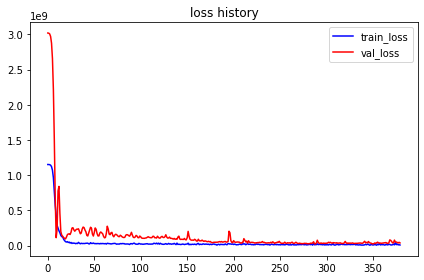

5/5 [==============================] - 0s 798us/step


In [545]:
"""
Predict the global spread of coronavirus with Dense modle
"""
pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, hidden_state=False, batch_size=8, n_feature=3, model_name='world_dense_pdm_reg', stateful=False)

hist = pdm_reg.fit(X_train=X_train.reshape(len(X_train), X_train.shape[1] * X_train.shape[2]), 
                   y_train=y_train, 
                   validation_data=(X_test.reshape(len(X_test), X_test.shape[1] * X_test.shape[2]), y_test),
                   verbose=1,
                   epochs=3000)
show_train_hist(hist)

pdm_reg.load_best_weights()
loss_and_metrics = pdm_reg.evaluate(X_test=X_test.reshape(len(X_test), X_test.shape[1] * X_test.shape[2]), y_test=y_test)

In [546]:
print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')
print('===================================================== Prediction of X_test =====================================================')
y_hat = pdm_reg.predict(X_test.reshape(len(X_test), X_test.shape[1] * X_test.shape[2]))
y_dict = {'Confirmed': [x[0] for x in y_hat],
          'Deaths':[x[1] for x in y_hat],
          'Recovered':[x[2] for x in y_hat]}
y_df = pd.DataFrame(y_dict)
y_df

MAE: 3368.989013671875, MAPE: 8.200743675231934
===================================================== Prediction of X_test =====================================================


,Confirmed,Deaths,Recovered
0,82103.406,2777.418,28869.496
1,83983.742,2847.829,29706.377
2,86628.773,2942.803,30770.178
3,89818.883,3056.136,32024.791
4,94883.430,3230.532,33881.484


In [547]:
n = 7
print(f'\n===================================================== Prediction of {n} days =====================================================')
prediction = pdm_reg.predict_n_days(n, X_test[-1], {'mean': _mean, 'std': _std})
prediction


===================================================== Prediction of 7 days =====================================================


,Confirmed,Deaths,Recovered
0,94883.430,3230.532,33881.484
1,98996.445,3372.164,35388.785
2,103557.227,3528.491,37042.898
3,108271.500,3689.473,38738.066
4,113883.109,3880.637,40744.551
5,120970.281,4121.412,43262.719
6,130094.047,4430.111,46473.297


In [548]:
print(df['Country/Region'].unique())
nation_name = 'South Korea'

['Mainland China' 'Hong Kong' 'Macau' 'Taiwan' 'US' 'Japan' 'Thailand'
 'South Korea' 'Singapore' 'Philippines' 'Malaysia' 'Vietnam' 'Australia'
 'Mexico' 'Brazil' 'Colombia' 'France' 'Nepal' 'Canada' 'Cambodia'
 'Sri Lanka' 'Ivory Coast' 'Germany' 'Finland' 'United Arab Emirates'
 'India' 'Italy' 'UK' 'Russia' 'Sweden' 'Spain' 'Belgium' 'Others' 'Egypt'
 'Iran' 'Israel' 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait'
 'Austria' 'Algeria' 'Croatia' 'Switzerland' 'Pakistan' 'Georgia' 'Greece'
 'North Macedonia' 'Norway' 'Romania' 'Denmark' 'Estonia' 'Netherlands'
 'San Marino' ' Azerbaijan' 'Belarus' 'Iceland' 'Lithuania' 'New Zealand'
 'Nigeria' 'North Ireland' 'Ireland' 'Luxembourg' 'Monaco' 'Qatar'
 'Ecuador' 'Azerbaijan' 'Czech Republic' 'Armenia' 'Dominican Republic'
 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco' 'Saudi Arabia'
 'Senegal']


In [551]:
korea_df = df[df['Country/Region'] == nation_name].groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
korea_df = korea_df.reset_index()
korea_df = korea_df.sort_values('ObservationDate', ascending=False)
korea_df.style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,4335,28,30
39,2020-03-01 00:00:00,3736,17,30
38,2020-02-29 00:00:00,3150,16,27
37,2020-02-28 00:00:00,2337,13,22
36,2020-02-27 00:00:00,1766,13,22
35,2020-02-26 00:00:00,1261,12,22
34,2020-02-25 00:00:00,977,10,22
33,2020-02-24 00:00:00,833,8,18
32,2020-02-23 00:00:00,602,6,18
31,2020-02-22 00:00:00,433,2,16


In [552]:
# for nation_name in df['Country/Region'].unique():
print(f'[{nation_name} spread of coronavirus19]')
_mean = np.mean(korea_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
_std = np.std(korea_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
    
X, y = seq2dataset(korea_df[['Confirmed', 'Deaths', 'Recovered']].values, WINDOW_SIZE)
X = (X - _mean) / _std
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

[South Korea spread of coronavirus19]


C:\Users\codez\PycharmProjects\CoronavirusDisease2019\model\2020-03-05;03.00.08\nation_dense_pdm_reg.best.hdf5
Train on 28 samples, validate on 5 samples
Epoch 1/3000
28/28 [==============================] - 2s 65ms/step - loss: 45764.6822 - mae: 61.0407 - mape: 45999624.0000 - val_loss: 3410390.0000 - val_mae: 1034.7686 - val_mape: 98.4779
Epoch 2/3000
28/28 [==============================] - 0s 1ms/step - loss: 44863.7075 - mae: 58.6118 - mape: 281848352.0000 - val_loss: 3380153.2500 - val_mae: 1028.6481 - val_mape: 91.9312
Epoch 3/3000
28/28 [==============================] - 0s 2ms/step - loss: 42553.1828 - mae: 55.5435 - mape: 1344914048.0000 - val_loss: 3300819.5000 - val_mae: 1012.9689 - val_mape: 78.5805
Epoch 4/3000
28/28 [==============================] - 0s 2ms/step - loss: 36621.4197 - mae: 57.0176 - mape: 1739921152.0000 - val_loss: 3130883.2500 - val_mae: 979.7904 - val_mape: 56.5524
Epoch 5/3000
28/28 [==============================] - 0s 1ms/step - loss: 27607.0527 - ma

Epoch 44/3000
28/28 [==============================] - 0s 2ms/step - loss: 1764.1273 - mae: 16.6859 - mape: 520462080.0000 - val_loss: 894230.6250 - val_mae: 510.4151 - val_mape: 109.9736
Epoch 45/3000
28/28 [==============================] - 0s 2ms/step - loss: 1930.5896 - mae: 19.4195 - mape: 455880960.0000 - val_loss: 794553.1875 - val_mae: 468.9114 - val_mape: 72.7335
Epoch 46/3000
28/28 [==============================] - 0s 2ms/step - loss: 1681.5375 - mae: 14.9217 - mape: 620247232.0000 - val_loss: 779480.5000 - val_mae: 470.1008 - val_mape: 90.0896
Epoch 47/3000
28/28 [==============================] - 0s 2ms/step - loss: 1099.5669 - mae: 13.4188 - mape: 648935488.0000 - val_loss: 936532.0000 - val_mae: 530.8944 - val_mape: 143.1008
Epoch 48/3000
28/28 [==============================] - 0s 2ms/step - loss: 591.8411 - mae: 11.1168 - mape: 731633792.0000 - val_loss: 1072207.3750 - val_mae: 560.0624 - val_mape: 105.3821
Epoch 49/3000
28/28 [==============================] - 0s 1ms/

Epoch 88/3000
28/28 [==============================] - 0s 1ms/step - loss: 3306.1306 - mae: 19.0403 - mape: 541459264.0000 - val_loss: 791355.6250 - val_mae: 460.9713 - val_mape: 45.8197
Epoch 89/3000
28/28 [==============================] - 0s 2ms/step - loss: 2209.2616 - mae: 17.0868 - mape: 461648064.0000 - val_loss: 1104933.3750 - val_mae: 563.0162 - val_mape: 47.3886
Epoch 90/3000
28/28 [==============================] - 0s 2ms/step - loss: 1817.4134 - mae: 17.3844 - mape: 409465312.0000 - val_loss: 1059432.7500 - val_mae: 551.8184 - val_mape: 59.4732
Epoch 91/3000
28/28 [==============================] - 0s 2ms/step - loss: 1118.4820 - mae: 12.2437 - mape: 489696224.0000 - val_loss: 829984.3750 - val_mae: 470.9611 - val_mape: 23.4513
Epoch 92/3000
28/28 [==============================] - 0s 2ms/step - loss: 2372.6797 - mae: 15.6047 - mape: 587114944.0000 - val_loss: 670027.1250 - val_mae: 422.9085 - val_mape: 60.6112
Epoch 93/3000
28/28 [==============================] - 0s 1ms/s

Epoch 175/3000
28/28 [==============================] - 0s 1ms/step - loss: 1058.2041 - mae: 13.0789 - mape: 509083872.0000 - val_loss: 358669.2500 - val_mae: 308.9256 - val_mape: 111.3331
Epoch 176/3000
28/28 [==============================] - 0s 1ms/step - loss: 2771.4207 - mae: 17.0613 - mape: 295158336.0000 - val_loss: 464639.2500 - val_mae: 357.5193 - val_mape: 77.7626
Epoch 177/3000
28/28 [==============================] - 0s 1ms/step - loss: 1551.1396 - mae: 14.8689 - mape: 386154944.0000 - val_loss: 782793.2500 - val_mae: 481.8097 - val_mape: 89.3094
Epoch 178/3000
28/28 [==============================] - 0s 1ms/step - loss: 1715.3083 - mae: 15.6504 - mape: 324318688.0000 - val_loss: 921351.8125 - val_mae: 520.5048 - val_mape: 77.6805
Epoch 179/3000
28/28 [==============================] - 0s 1ms/step - loss: 1527.0951 - mae: 14.5601 - mape: 448058080.0000 - val_loss: 823618.8125 - val_mae: 484.4438 - val_mape: 62.9934
Epoch 180/3000
28/28 [==============================] - 0s 

Epoch 262/3000
28/28 [==============================] - 0s 2ms/step - loss: 880.9267 - mae: 9.7822 - mape: 199739760.0000 - val_loss: 849373.1250 - val_mae: 492.4764 - val_mape: 54.7071
Epoch 263/3000
28/28 [==============================] - 0s 1ms/step - loss: 1005.2386 - mae: 11.3474 - mape: 247729360.0000 - val_loss: 818686.8125 - val_mae: 482.9019 - val_mape: 60.3505
Epoch 264/3000
28/28 [==============================] - 0s 2ms/step - loss: 1745.7190 - mae: 13.1090 - mape: 268028384.0000 - val_loss: 667560.1250 - val_mae: 423.2098 - val_mape: 31.9965
Epoch 265/3000
28/28 [==============================] - 0s 2ms/step - loss: 2008.2359 - mae: 14.6307 - mape: 270093600.0000 - val_loss: 457439.3125 - val_mae: 337.3964 - val_mape: 47.4667
Epoch 266/3000
28/28 [==============================] - 0s 2ms/step - loss: 2482.9504 - mae: 15.5176 - mape: 150312800.0000 - val_loss: 386081.6562 - val_mae: 309.3695 - val_mape: 57.6062
Epoch 267/3000
28/28 [==============================] - 0s 1ms

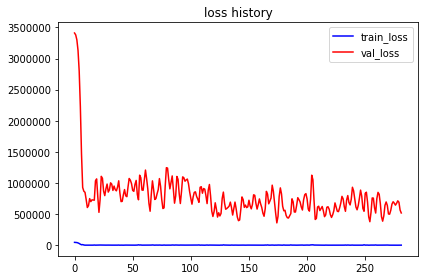

In [553]:
"""
Predict the korea spread of coronavirus with Dense modle
"""
k_pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, hidden_state=False, batch_size=8, n_feature=3, model_name='korea_dense_pdm_reg', stateful=False)

hist = k_pdm_reg.fit(X_train=X_train.reshape(len(X_train), X_train.shape[1] * X_train.shape[2]), 
                   y_train=y_train, 
                   validation_data=(X_test.reshape(len(X_test), X_test.shape[1] * X_test.shape[2]), y_test),
                   verbose=1,
                   epochs=3000)
show_train_hist(hist)
k_pdm_reg.load_best_weights()
loss_and_metrics = k_pdm_reg.evaluate(X_test=X_test.reshape(len(X_test), X_test.shape[1] * X_test.shape[2]), y_test=y_test)

In [555]:
print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')
print('===================================================== Prediction of X_test =====================================================')
y_hat = k_pdm_reg.predict(X_test.reshape(len(X_test), X_test.shape[1] * X_test.shape[2]))
y_dict = {'Confirmed': [x[0] for x in y_hat],
          'Deaths':[x[1] for x in y_hat],
          'Recovered':[x[2] for x in y_hat]}
y_df = pd.DataFrame(y_dict)
y_df

MAE: 3368.989013671875, MAPE: 8.200743675231934
===================================================== Prediction of X_test =====================================================


,Confirmed,Deaths,Recovered
0,1502.100,13.617,21.835
1,1701.298,15.367,24.508
2,1891.450,17.001,26.995
3,2125.673,19.018,30.066
4,2395.518,21.367,33.687


In [556]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
n = 7
print(f'\n===================================================== Prediction of {n} days =====================================================')
prediction = k_pdm_reg.predict_n_days(n, X_test[-1], {'mean': _mean, 'std': _std})
prediction


===================================================== Prediction of 7 days =====================================================


,Confirmed,Deaths,Recovered
0,2395.519,21.367,33.687
1,2643.851,23.501,36.977
2,2741.230,24.326,38.187
3,3034.220,27.036,42.391
4,3338.232,29.680,46.512
5,3682.365,32.783,51.330
6,4179.766,37.208,58.142
